## Some docs for the software

let `log` be one fulllog, i.e. one entry in `d`.
- `log["glpk_solution"]` is either a solution or `False` if there was an exception, which is most likely a timeout
- `log["augip_init_time"]` is the time it took to initialize the AugIP MILP instance
- `log["glpk_solve_time"]` is time taking by Gurobi to *solve* the model
- `log["glpk_construct_and_solve"]` is time taken by Gurobi to 1) construct the model, 2) solve it
- `log["iterations"][i]["gammas"][gamma]["solve_time"]` is time taken by the AugIP routine to find the augmenting step in iteration $i$ and for $\gamma$=`gamma`.
- `log["iterations"][i]["gammas"][gamma]["solve_sucess"]` is a bool indicating if the `p.solve()` ended with an exception or not (timeout)

Note that now we are by default loading "stripped" data which means we delete most information which we do not use, such as the changing current solution and the discovered augmenting steps.
We just retain data such as times, values of solutions, etc.
The full information is contained in `[hash].pickle` files, while stripped data is in `[hash].stripped.pickle` files.
The format is otherwise the same.


let `df` be the master pandas DataFrame generated from `d`. It has the following columns, and we explain their possible values and meaning:
- `dimension`: the dimension of the IP.
- `Delta`: the maximum coefficient of the constraint matrix.
- `n`: number of bricks of the $n$-fold IP.
- `r`: number of rows of the block $D$. Note that $s$, which is the number of rows of matrix $A$, is $1$ in both formulations.
- `t`: number of columns of a brick.
- `gc`: the parameter $\texttt{g}_1$ used in this computation.
- `Gamma`: the augmentation strategy $\Gamma$ which was used. One of `unit`, `best`, `log2`, `log5`, `log10`.
- `gamma`: the step-length $\gamma$ used in this computation. $-1$ if doesn't make sense (see below).
- `last_gamma`: `True` if this gamma was the largest tested in this iteration, `False` otherwise.
- `time`: time this computation took.
- `time type`: one of the following:
   - `total`: total time taken by the iterative algorithm to solve this instance,
   - `aug total`: total time take by the augmentation oracle (excluding the initialization),
   - `aug init`: time to initialize the augmentation oracle (i.e., MILP model construction),
   - `aug scaled 10^2`: time of one call to augmentation oracle (i.e., change of bounds of MILP model + solve), scaled by 100. Only for this `time type` is `gamma` $>0$.
   - `aug average scaled 10^2`: average of the above for this instance,
   - `gurobi solve scaled 10^2`: time taken by Gurobi to solve this instance, scaled by 100,
   - `gurobi construct & solve`: time taken by Gurobi to construct & solve this instance, scaled by 100.
- `iter`: the number of outer iteration (i.e., trying all $\gamma \in \Gamma$) in which this computation occured. $-1$ unless `time type` is `aug scaled 10^2`.
- `obj`: objective value of this computation.
- `obj type`: one of the following:
   - `gurobi` if `time type` is `gurobi*`. Then `obj` is the exact optimum.
   - `aug` if `time type` is not `gurobi*` and not `aug scaled 10^2`. Then `obj` is the solution obtained by the iterative algorithm.
   - `actual` if `time type` is `aug scaled 10^2`. Then `obj` is objective value which would be obtained with this augmenting step.
   - `min` if `time type` is `aug scaled 10^2`. Then `obj` is the best objective obtained across all $\gamma \in \Gamma$, i.e., the objective value from which we start in the next outer iteration.
- `directory`: full path of directory from which this log comes. Useful to identify different runs ($\Gamma$ or $\texttt{g}_1$) of the same problem instance.
- `gap`: `obj` minus the milp optimum of this instance.
- `convergence`: the convergence rate of this $(\Gamma, \texttt{g}_1)$ tuple (defined below)
- `fail`: `True` if this particular run of Gurobi timed out, `False` otherwise.


Other notes:
- We actually never use GLPK, so mentally replace all "glpk" with "Gurobi". However, the default solver of SageMath is GLPK and everything should work (albeit much more slowly) with GLPK as well.
- an older version of the paper called the step length $\gamma$ so we retain it here. The new name is $\lambda$.

Pandas hints:
- if `df` is a DataFrame with column `col` and we want to select only rows where in `col` the value is `val`, it's enough to set `df_new = df[df.col == val]`. If `col` has spaces and cannot be written in the dot notation, one may use directly `df[df[col] == val]` (bracket notation).

## Parameters of generated data
`./nfold_sched_tester.sage --logdir logs_small --machines 10 20 30 40 --count_for_each_p 1 --slacks 0.6 0.7 --p_s 6 7 8 9 10 11 --number_job_types 4 5 6 --gammas log2 log5 unit --gc 5 10 15 20 25 30 40 50 75 100`

`./nfold_sched_tester.sage.py --instance_type cs --logdir cs_test --milp_timelimit 300 --augip_timelimit 300`

In [18]:
from plotter_jea import load_data, master_df, heatmap_data
from __future__ import print_function
from functools import partial
import pandas
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Part 1: Qualitative Evaluation

- we pick one scheduling and one Closest String instance

There are two main points:
- Regarding the augmentation strategy $\Gamma$:
   - best takes a lot of time per iteration,
   - unit is erratic and doesn't improve with increasing gc,
   - log2/log5/log10 behave well
- Regarding the tuning parameter $\texttt{g}_1$:
   - if too small, gets stuck before reaching optimum
   - larger, converges slowly to optimum
   - then with growing $\texttt{g}_1$ convergence gets faster.

#### Plots
- for one sched and one cs instance, we have
  - FacetGrid comparing the different $\Gamma$ and values of $\texttt{g}_1$,
  - Series of lineplots, one lineplot for one $\Gamma$, showing how convergence improves wrt growing $\texttt{g}_1$.


## Scheduling

In [2]:
SINGLE_SCHED_LOGDIR = "./logs_6/540/31/QCmax_m_60_lengths_2_11_13_31_weigths_31_13_11_2_smallest_155_largest_5350_slack_r_0.70_obj_total_jobs_92684"
single_sched_d = load_data(SINGLE_SCHED_LOGDIR)          
single_sched_df = master_df(single_sched_d)

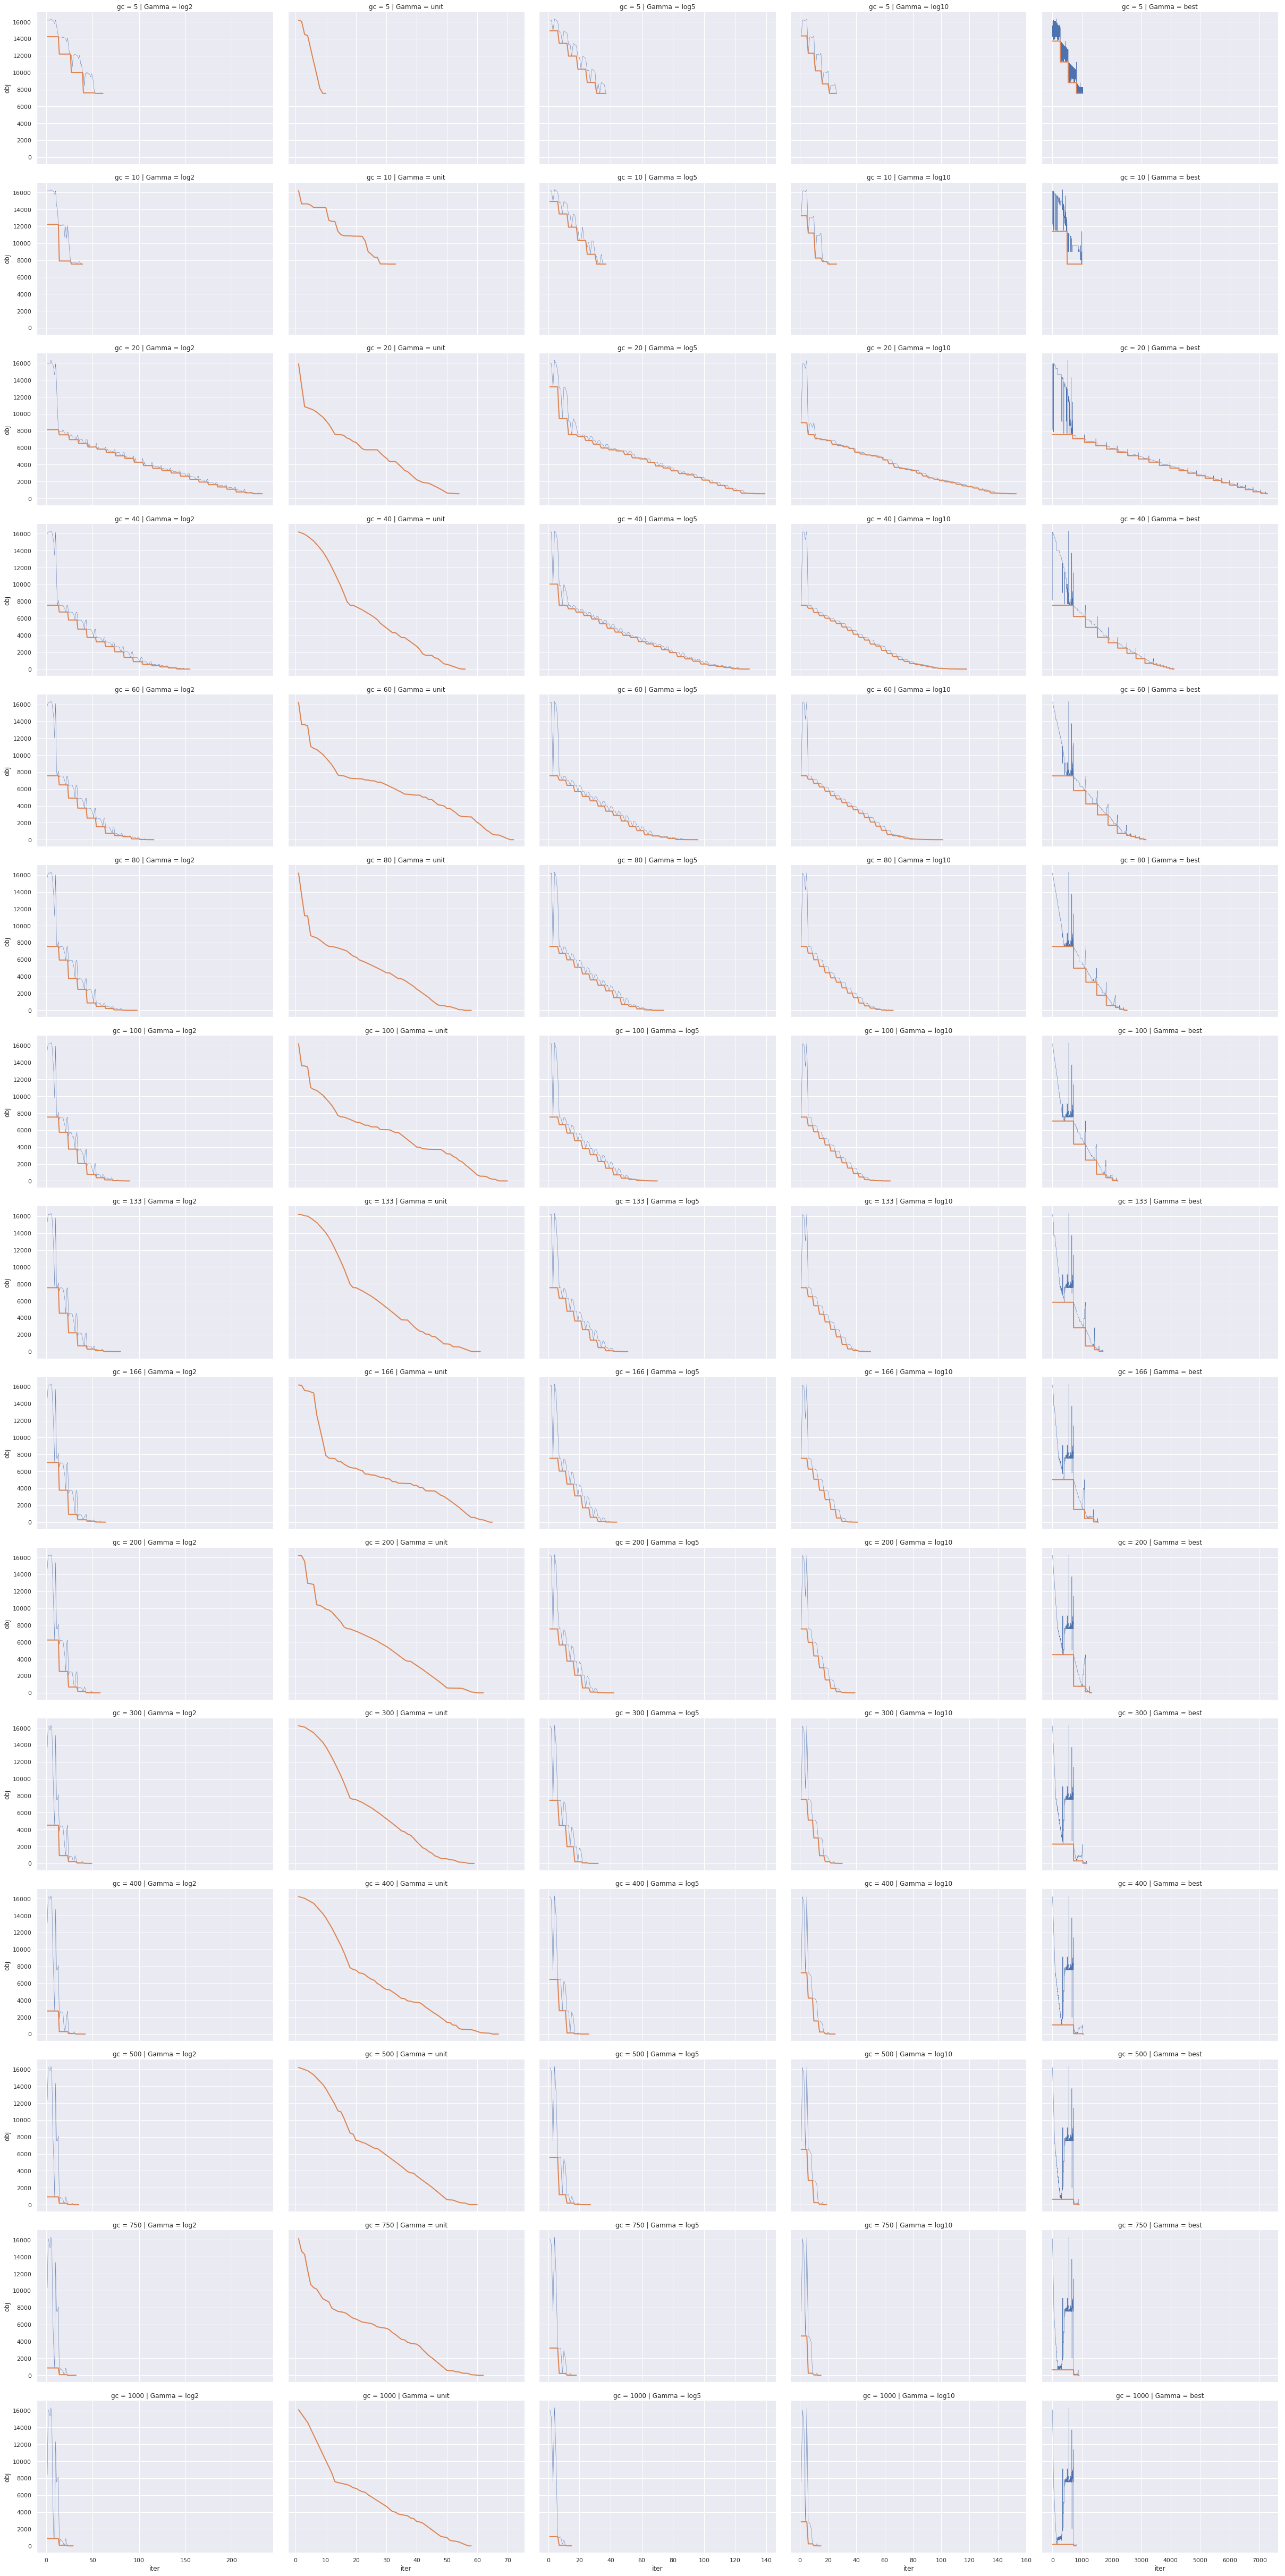

In [69]:
fcg1 = sns.FacetGrid(data=single_sched_df, col="Gamma",  row="gc", height=4.5, aspect=1.5, sharex="col")
fcg1 = fcg1.map(sns.lineplot, "iter", "obj", "obj type", "obj type", size_order=["min", "actual"])
fcg1.fig.savefig("figs/fcg1.pdf")

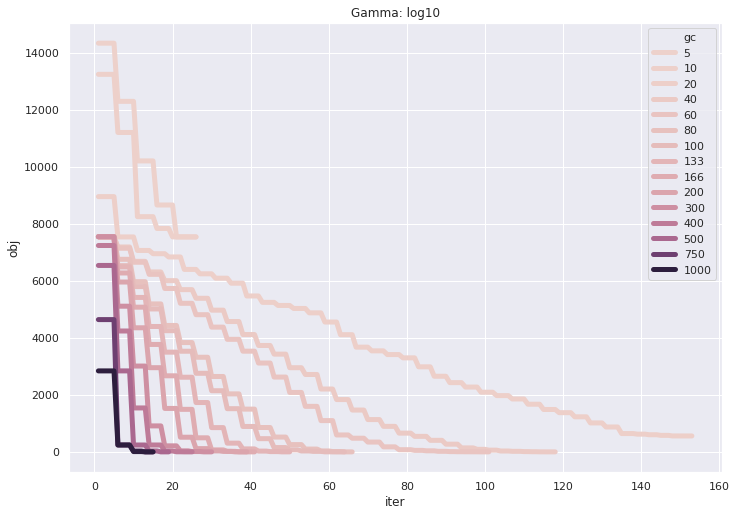

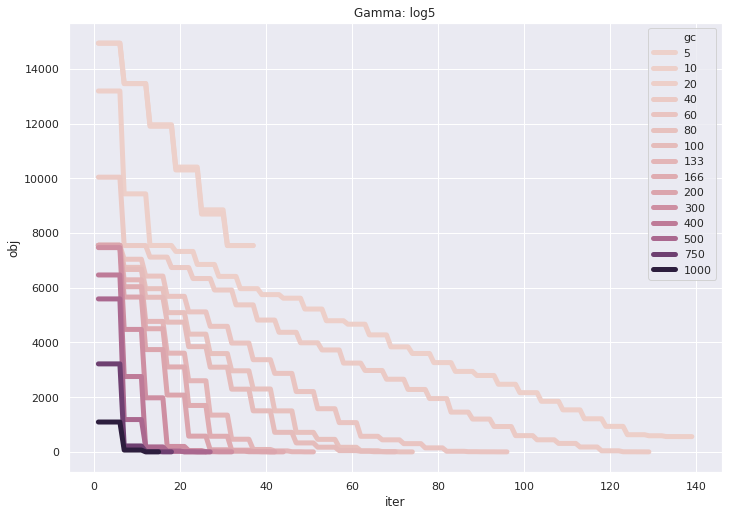

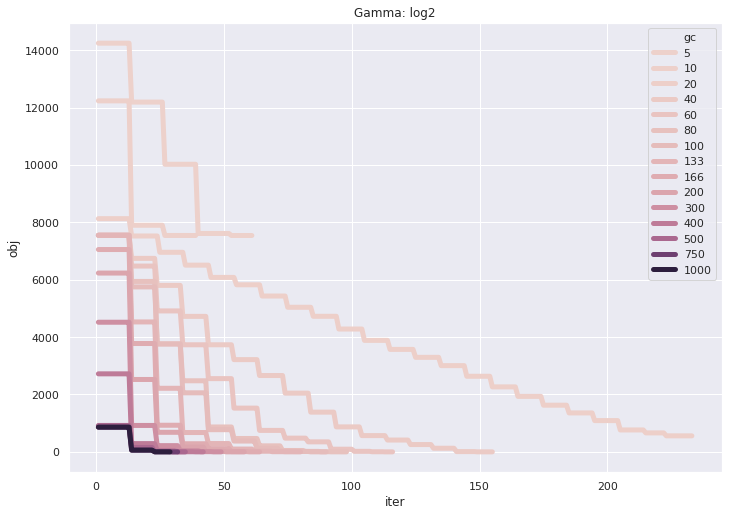

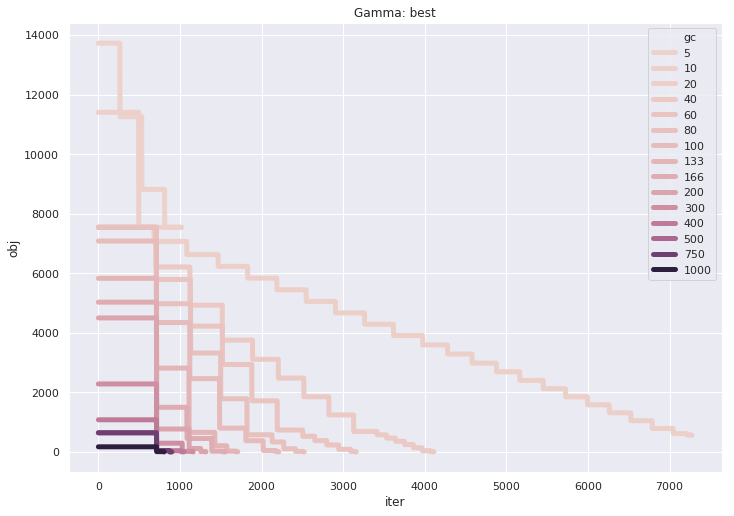

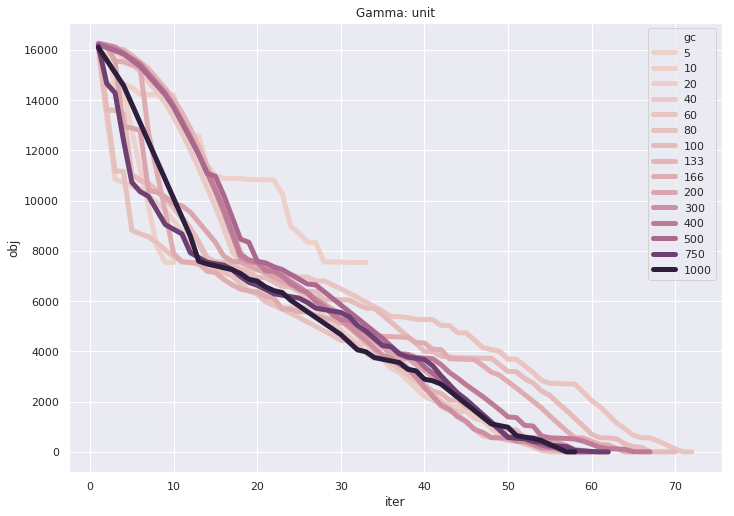

In [70]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(rc={"lines.linewidth": 5})
gammas = set(single_sched_df.Gamma.values)
for (i,g) in enumerate(gammas):
    df_g = single_sched_df[single_sched_df.Gamma == g]
    df_g_min = df_g[df_g["obj type"] == "min"]
    plt.figure()
    plot = sns.lineplot(x="iter", y="obj", hue="gc", data=df_g_min, legend="full")
    plt.title("Gamma: "+g)
    plot.figure.savefig("figs/sched_"+g+".pdf")
sns.set(rc={"lines.linewidth": 1})

## Closest String

`./nfold_sched_tester.sage.py --instance_type cs --logdir cs_test_2 --gammas unit best log2 log5 log10 --milp_timelimit 300 --augip_timelimit 300 --str_len 8000 --str_num 3 --sigma 4 --distance_factor 0.1 0.15 0.2 0.25 0.3 --gc_values 2 4 6 8 10 12 15 20 25 30 35 40 45 50 60 70 80 90 100`

In [6]:
#SINGLE_CS_LOGDIR = "./cs_test_2/480/1/cs_8000_3_3_4_0.20_45147"
SINGLE_CS_LOGDIR="./cs_test_2/480/1/cs_8000_3_4_4_0.30_37084"
single_cs_d = load_data(SINGLE_CS_LOGDIR)
single_cs_df = master_df(single_cs_d)

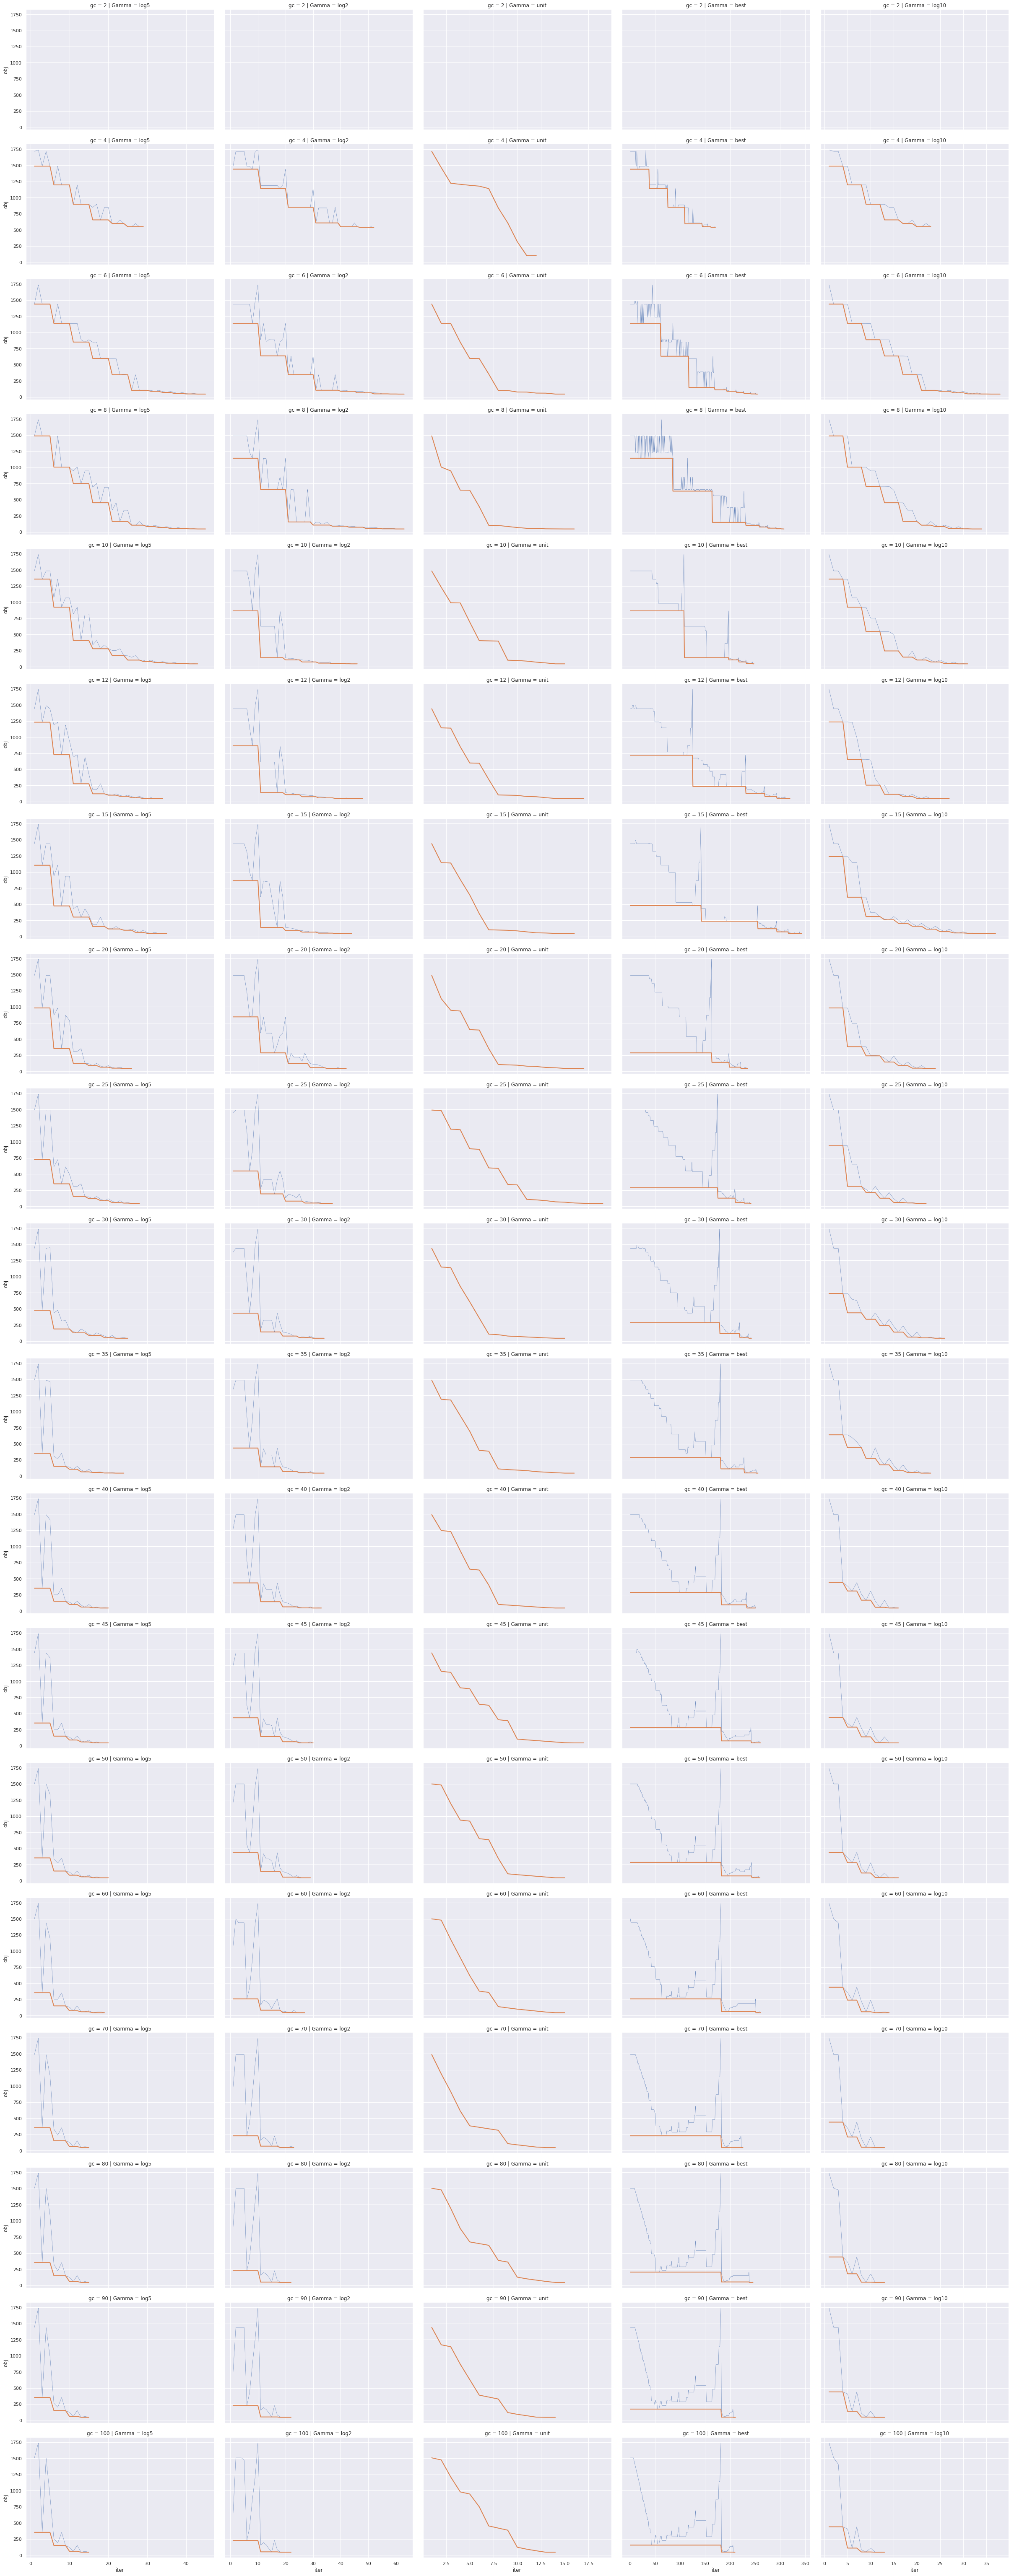

In [68]:
fcg2 = sns.FacetGrid(data=single_cs_df, col="Gamma",  row="gc", height=4.5, aspect=1.5, sharex="col")
fcg2 = fcg2.map(sns.lineplot, "iter", "obj", "obj type", "obj type", size_order=["min", "actual"])
fcg2.fig.savefig("figs/fcg2.pdf")

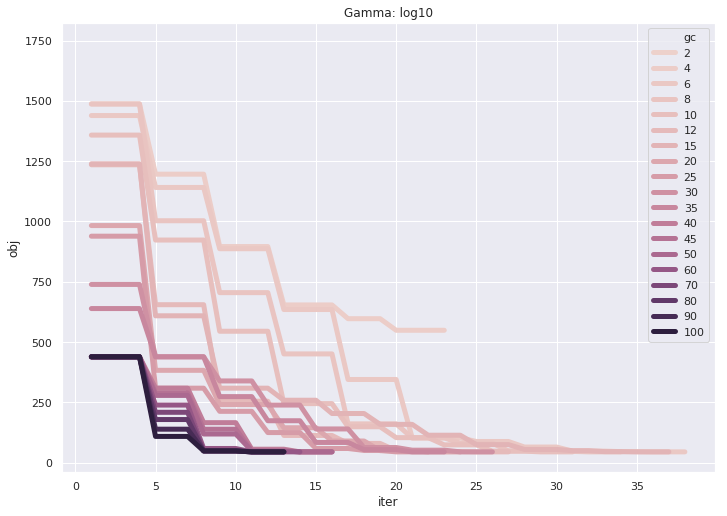

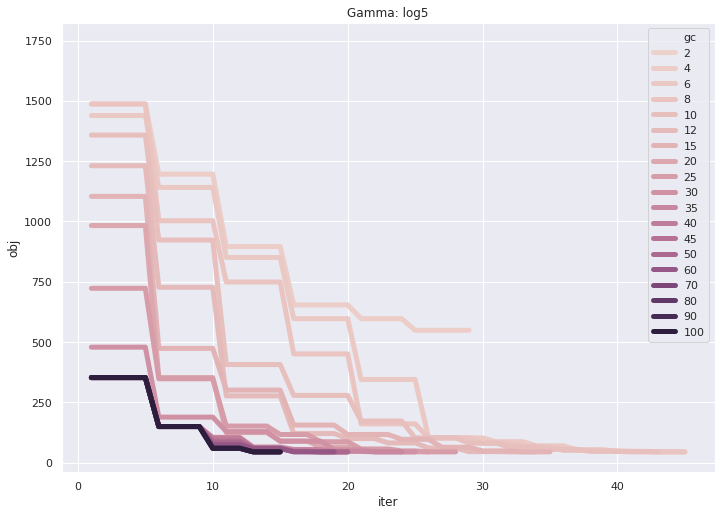

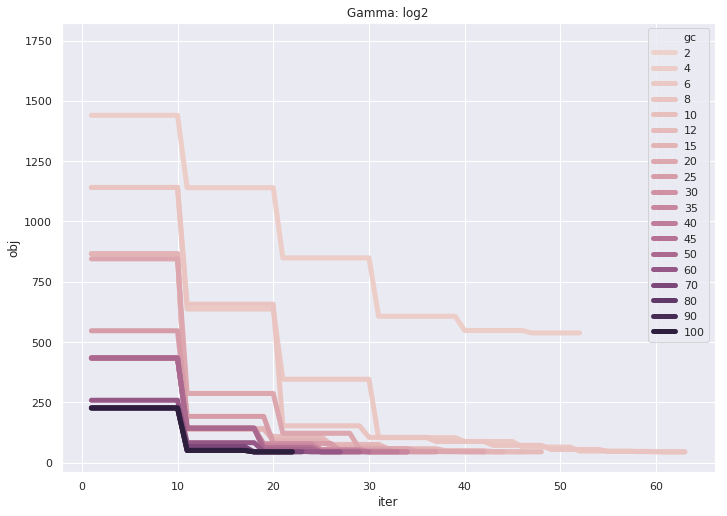

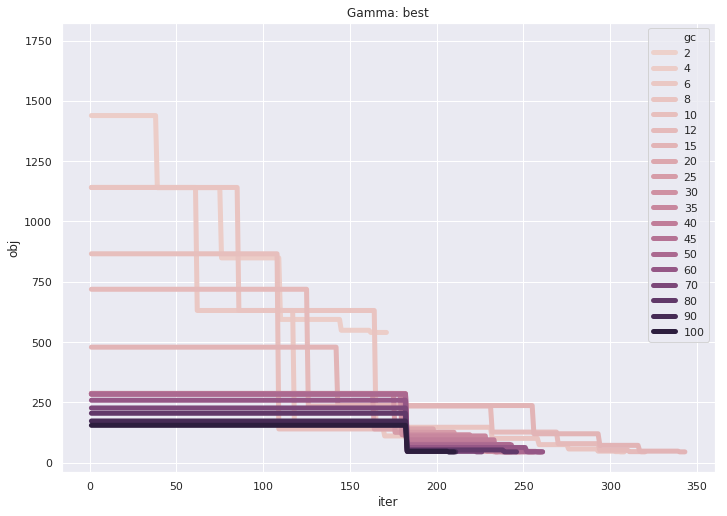

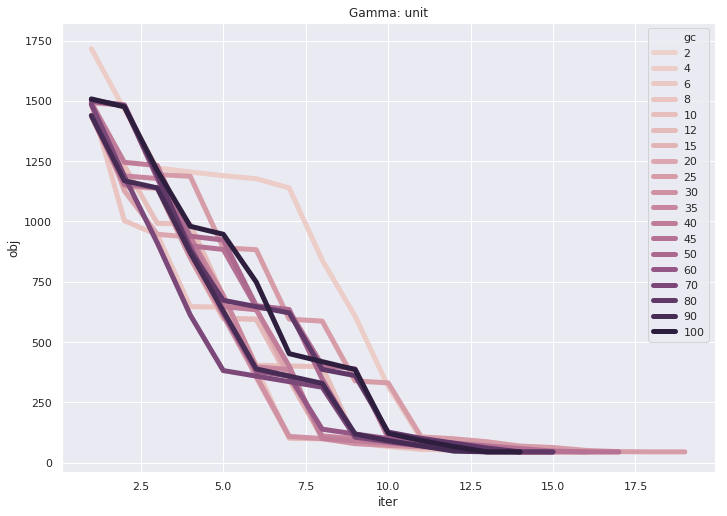

In [67]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(rc={"lines.linewidth": 5})
gammas = set(single_cs_df.Gamma.values)
for (i,g) in enumerate(gammas):
    df_g = single_cs_df[single_cs_df.Gamma == g]
    df_g_min = df_g[df_g["obj type"] == "min"]
    plt.figure()
    plot = sns.lineplot(x="iter", y="obj", hue="gc", data=df_g_min, legend="full")
    plt.title("Gamma: "+g)
    plot.figure.savefig("figs/cs_"+g+".pdf")
sns.set(rc={"lines.linewidth": 1})

# Part 2: Quantitative Evaluation

First, we fix $\Gamma = \Gamma_2$, i.e., the augmentation strategy will always be `log2`.

We would like to quantify the relationship of several parameters:
- dimension,
- max coefficient $\Delta$,
- size of brick $t$,
- "height" of brick $r$,
- number of bricks $n$
- tuning parameter $\texttt{g}_1$,
- optimality gap `native_solution` - `glpk_solution`
- convergence. This needs to be normalized:
   - let $it(\texttt{g}_1)$ be the number of iterations that it took to reach the optimum with tuning parameter $\texttt{g}_1$, with $+\infty$ if gap $>0$.
   - let $it_{\min}$ to be the minimum number of iterations (=number of iterations for largest $\texttt{g}_1$)
   - let the convergence rate $c(\texttt{g}_1)$ for parameter $\texttt{g}_1$ be defined as $c(\texttt{g}_1) = \frac{it_{\min}}{it(\texttt{g}_1)}$. Thus $c(\texttt{g}_1)$ is between $0$ and $1$ with $1$ being fastest convergence and $0$ meaning it didn't reach the optimum at all.

For CS, dimension, $n$, and $\Delta$ essentially don't make sense because dimension and $n$ are determined by $r$ (roughly, because we do some preprocessing and the number of actually present columns does not have to be identical for all instances with the same $r$), and $\Delta = 1$.

The main question is: **which parameters make it necessary to increase $\texttt{g}_1$?** We "need to increase $\texttt{g}_1$" if we either don't reach the optimum (gap $>0$) or we only reach it slowly, so this relates to parameters gap and $c(\texttt{g}_1)$.


#### Plots
For these plots filter out all entries of the inner loop, e.g. `df[df["obj type"] == "aug"][df["time type"] == "total"]`.

For scheduling, we have heatmaps $\Delta$ / $\texttt{g}_1$ / gap and $\Delta$ / $\texttt{g}_1$ / convergence, and similarly for dimension instead of $\Delta$.
Moreover we have a FacetGrid of heatmaps with similar breakdown.

For CS, we have similar heatmaps with $r$ instead of $\Delta$

In [7]:
#LOGDIR="logs_sched_8"
SCHED_LOGDIR="logs_small"
sched_d = load_data(SCHED_LOGDIR)
sched_df = master_df(sched_d)
sched_df_filter = sched_df[sched_df["obj type"] == "aug"][sched_df["time type"] == "total"]

/aux/alquaknaa/ipython/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


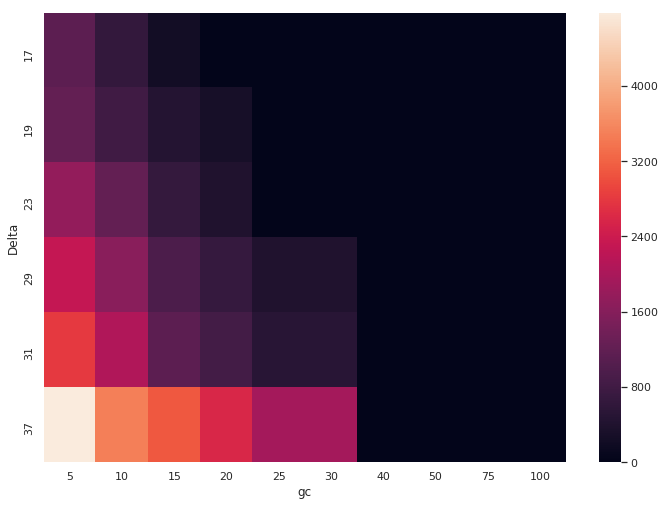

In [54]:
heat_data_1 = heatmap_data(sched_df_filter, "Delta", "gc", "gap")
hmap_1 = sns.heatmap(data=heat_data_1, annot=False)
hmap_1.figure.savefig("figs/sched_hmap_Delta_gc_gap.pdf")

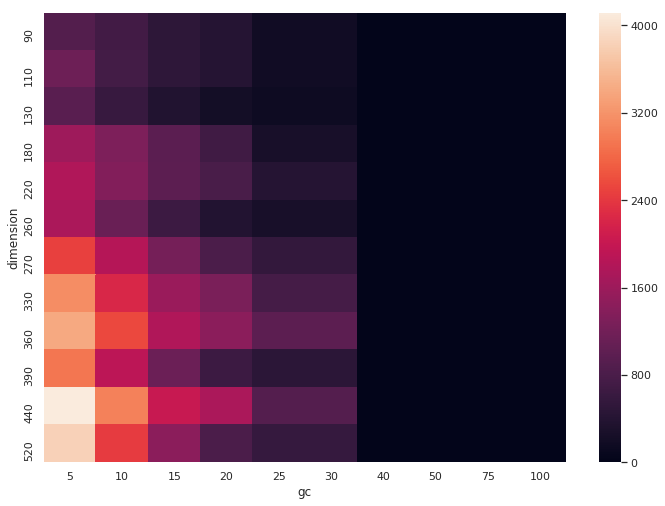

In [64]:
heat_data_1_dim = heatmap_data(sched_df_filter, "dimension", "gc", "gap")
hmap_1_dim = sns.heatmap(data=heat_data_1_dim, annot=False)
hmap_1_dim.figure.savefig("figs/sched_hmap_dim_gc_gap.pdf")

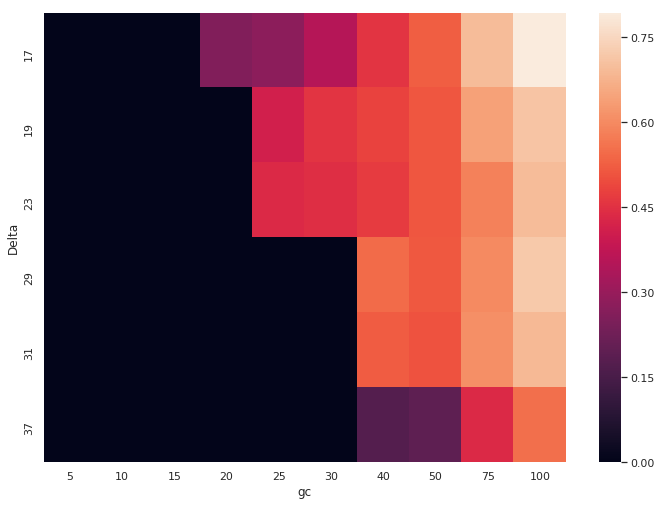

In [55]:
heat_data_2 = heatmap_data(sched_df_filter, "Delta", "gc", "convergence")
hmap_2 = sns.heatmap(data=heat_data_2)
hmap_2.figure.savefig("figs/sched_hmap_Delta_gc_convergence.pdf")

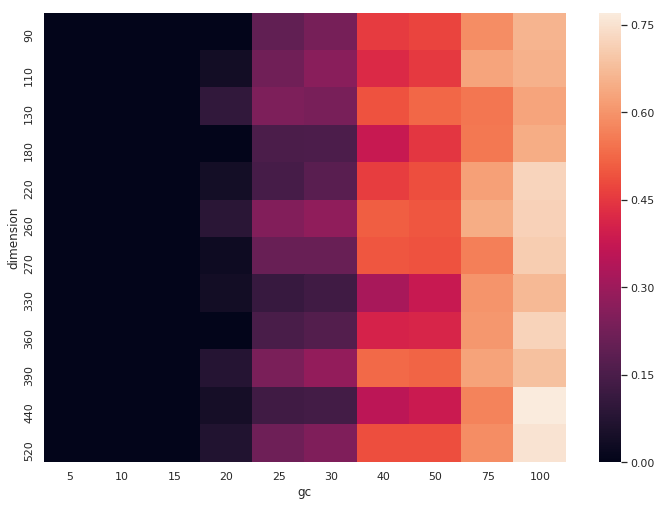

In [65]:
heat_data_2_dim = heatmap_data(sched_df_filter, "dimension", "gc", "convergence")
hmap_2_dim = sns.heatmap(data=heat_data_2_dim)
hmap_2_dim.figure.savefig("figs/sched_hmap_dim_gc_convergence.pdf")

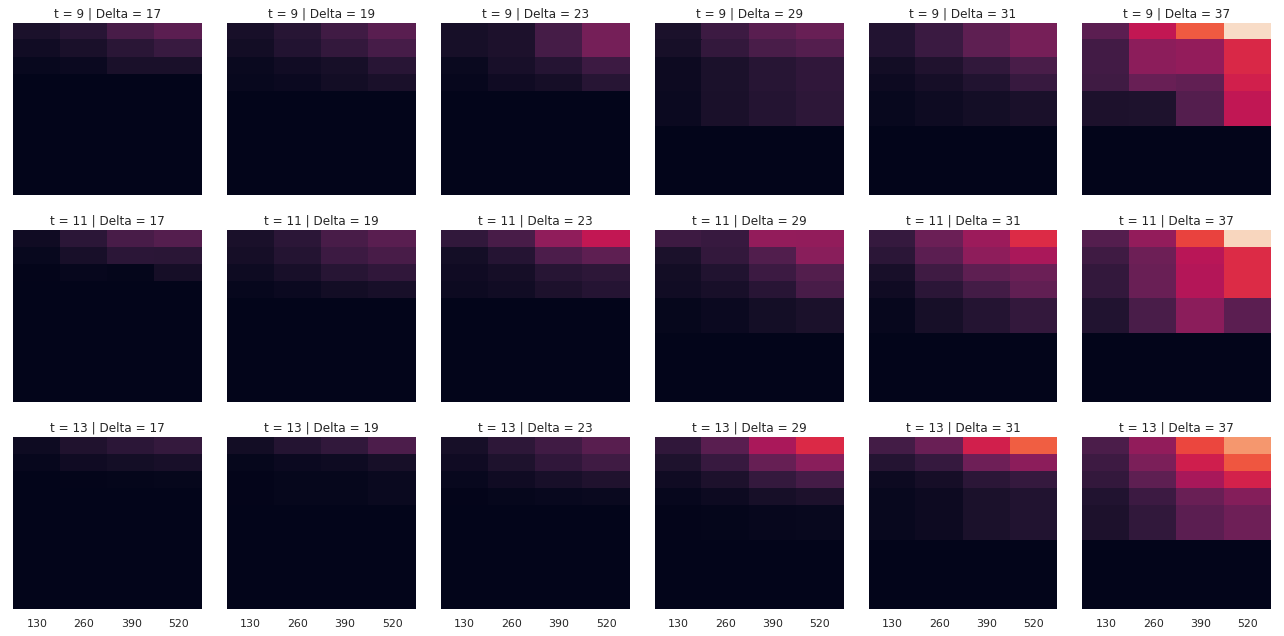

In [56]:
def facet_heatmap(vmax, vmin, values, index, columns, data, **kws):
    data = pandas.pivot_table(data, values=values, index=index, columns=columns, aggfunc=np.mean)
    sns.heatmap(data, vmin=vmin, vmax=vmax, cbar=False, yticklabels=False, **kws)

value = "gap"
facet_heatmap_args = partial(facet_heatmap, vmax=sched_df_filter[value].max(), vmin=sched_df_filter[value].min(),
                                  values=value, index=["gc"], columns=["dimension"])

fcg3 = sns.FacetGrid(sched_df_filter, col="Delta", row="t", height=3, aspect=1)
fcg3 = fcg3.map_dataframe(facet_heatmap_args)
fcg3.fig.savefig("figs/fcg3.pdf")

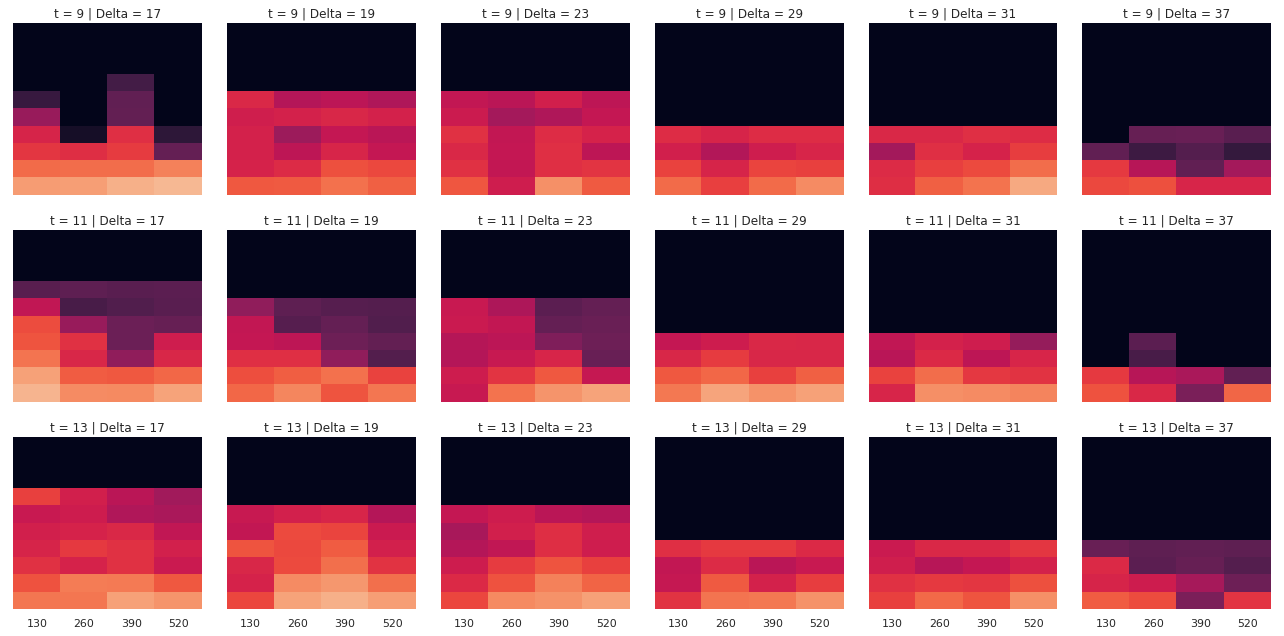

In [57]:
value = "convergence"
facet_heatmap_args = partial(facet_heatmap, vmax=sched_df_filter[value].max(), vmin=sched_df_filter[value].min(),
                                  values=value, index=["gc"], columns=["dimension"])

fcg4 = sns.FacetGrid(sched_df_filter, col="Delta", row="t", height=3, aspect=1)
fcg4 = fcg4.map_dataframe(facet_heatmap_args)
fcg4.fig.savefig("figs/fcg4.pdf")

## Closest String
- heatmap with rows = $r$, cols = $\texttt{g}_1$, vals = gap
- heatmap with rows = $r$, cols = $\texttt{g}_1$, vals = $c(\texttt{g}_1)$


In [8]:
CS_LOGDIR="cs_test"
cs_d = load_data(CS_LOGDIR)
cs_df = master_df(cs_d)
cs_df_filter = cs_df[cs_df["obj type"] == "aug"][cs_df["time type"] == "total"]

/aux/alquaknaa/ipython/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


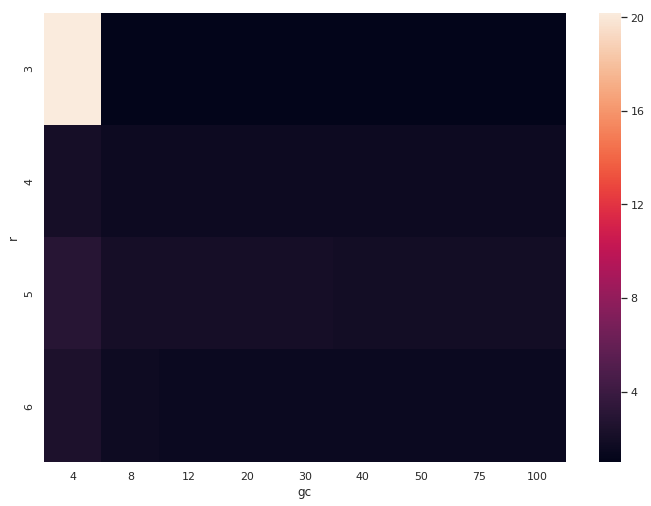

In [58]:
heat_data_3 = heatmap_data(cs_df_filter, "r", "gc", "gap")
hmap_3 = sns.heatmap(data=heat_data_3)
hmap_3.figure.savefig("figs/cs_hmap_r_gc_gap.pdf")

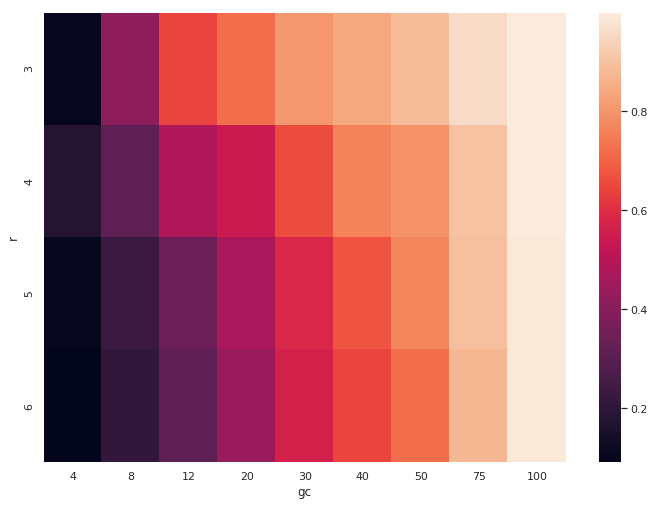

In [59]:
heat_data_4 = heatmap_data(cs_df_filter, "r", "gc", "convergence")
hmap_4 = sns.heatmap(data=heat_data_4)
hmap_4.figure.savefig("figs/cs_hmap_r_gc_convergence.pdf")

## Part 3: Towards Practical Improvements
So far we have investigated the iterative algorithm. Now we turn our attention to making it practical. So we finally ask about actual times needed for these computations. The main question here is **on what instances could $n$-fold IP beat Gurobi?** This can be rephrased more specifically as **which parameter make instances difficult for Gurobi?** If we could answer this question positively, then by the good asymptotics of the $n$-fold IP algorithm, there for large enough values of the parameter it should be possible to find an instance which is solved faster by $n$-fold IP than by Gurobi.

Unfortunatelly, our search is not successful and we leave this as an open question for future research.

Relevant parameters here:
- dimension (for CS strongly related to $r$ and $t$)
- $\Delta$
- $r$
- $t$ (for CS $t \leq r^r$)
- `total` -- total time for the iterative algorithm
- `aug total` -- total time spent on aug calls
- `aug init` -- time spent on initializing the aug oracle
- `gurobi construct & solve` -- construction of a MILP instance for the original instance + solution

#### Plots
- lineplot of the various times wrt parameters dimension / $\Delta$ / $r$ / $t$
- heatmaps for each time type wrt rows = $\Delta$, cols = dimension / $r$ / $t$

/aux/alquaknaa/ipython/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


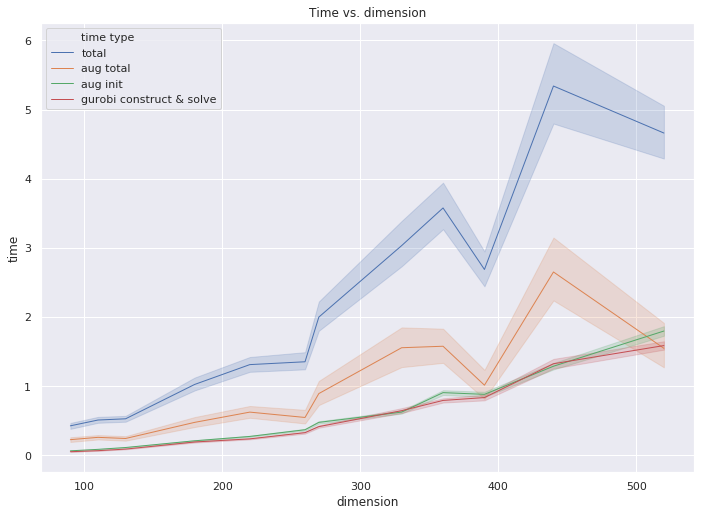

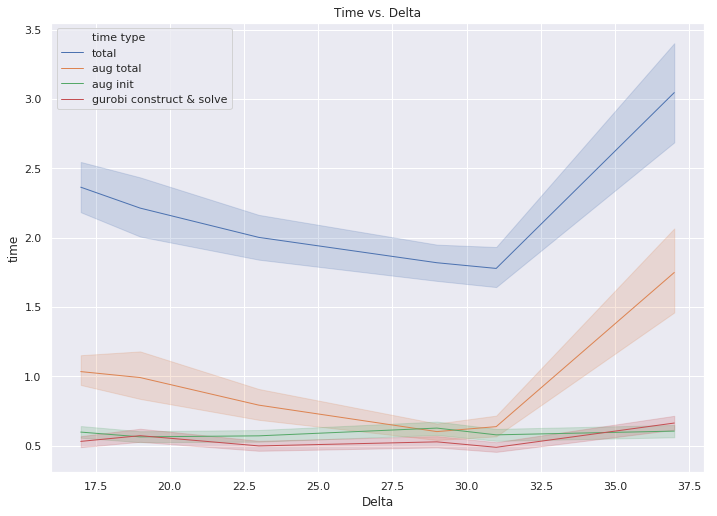

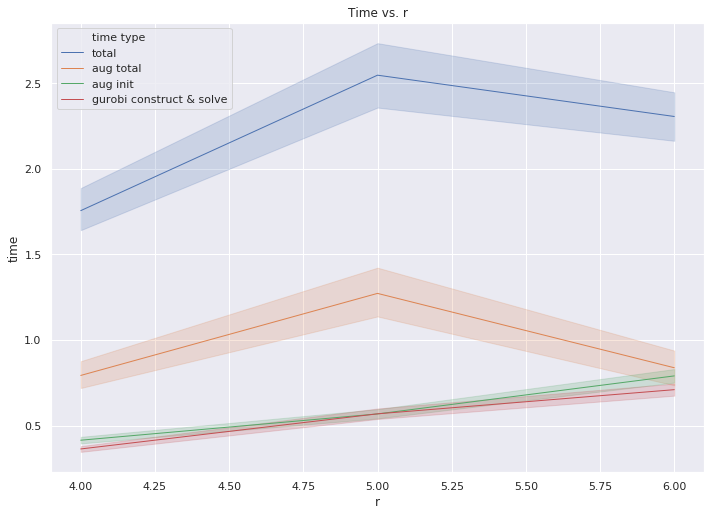

In [60]:
sched_df_filter2 = sched_df[sched_df["time type"] != "aug scaled 10^2"][sched_df["time type"] != "gurobi solve scaled 10^2"][sched_df["time type"] != "aug average scaled 10^2"]
df = sched_df_filter2
for x in ["dimension", "Delta", "r"]:
    plt.figure()
    plot = sns.lineplot(x=x, y="time",data=df, hue="time type")
    plt.title("Time vs. "+x)
    plot.figure.savefig("figs/sched_time_vs_"+x+".pdf")

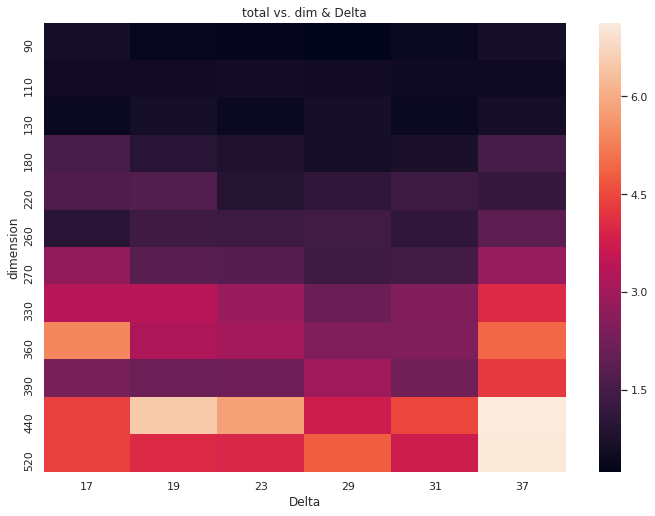

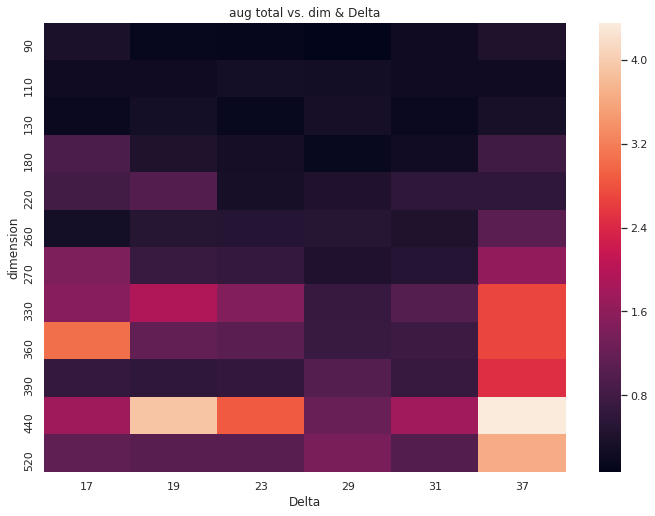

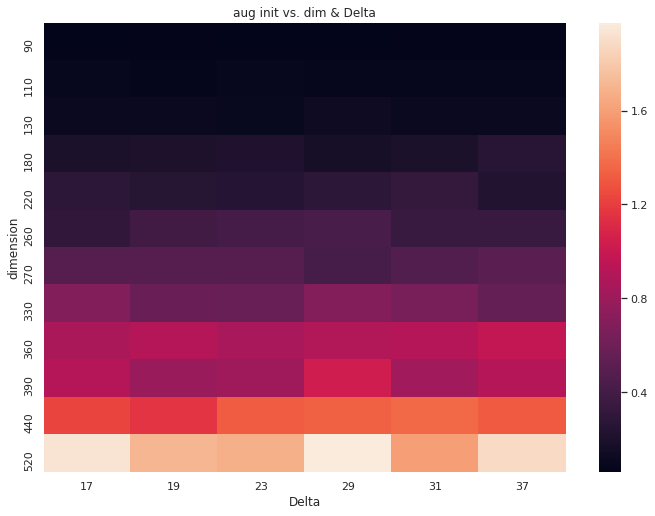

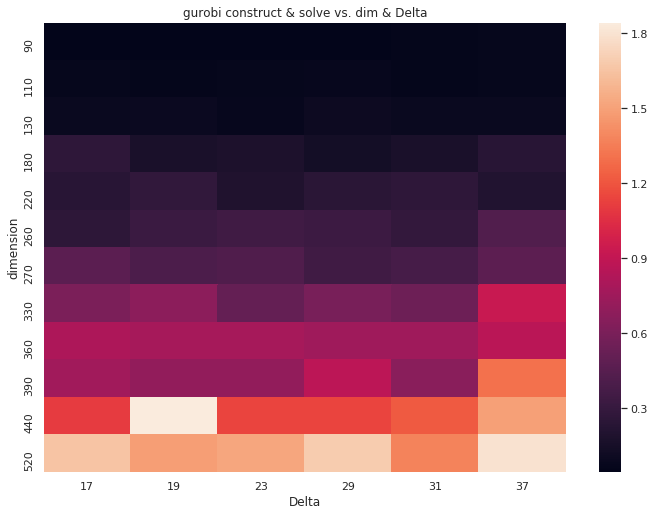

In [63]:
main_df = sched_df
for time_type in ["total", "aug total", "aug init", "gurobi construct & solve"]:
    df = main_df[main_df["time type"] == time_type]
    heat_data = heatmap_data(df, "dimension", "Delta", "time")
    plt.figure()
    plot = sns.heatmap(data=heat_data)
    plt.title(time_type + " vs. dim & Delta")
    plot.figure.savefig("figs/sched_hmap_"+time_type.replace(" ", "_")+"_vs_dim_Delta.pdf")

/aux/alquaknaa/ipython/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


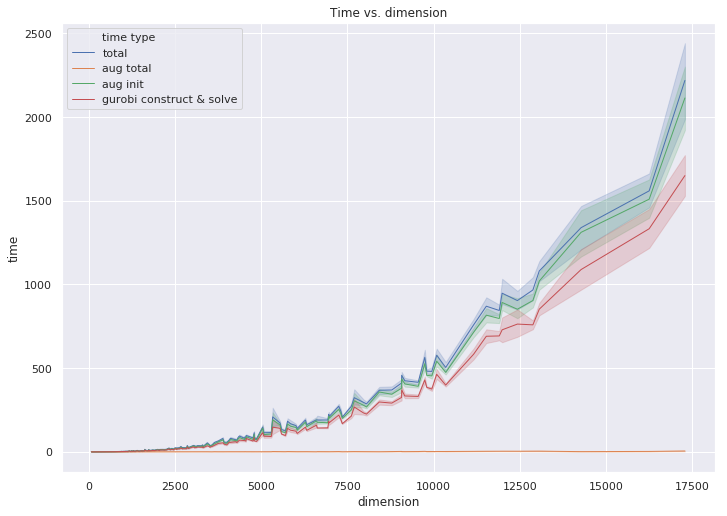

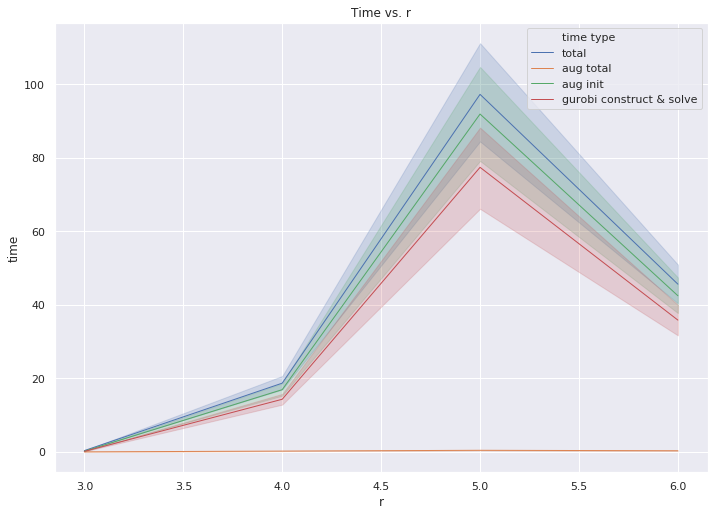

In [61]:
cs_df_filter2 = cs_df[cs_df["time type"] != "aug scaled 10^2"][cs_df["time type"] != "gurobi solve scaled 10^2"][cs_df["time type"] != "aug average scaled 10^2"]
df = cs_df_filter2
for x in ["dimension", "r"]:
    plt.figure()
    plot = sns.lineplot(x=x, y="time",data=df, hue="time type")
    plt.title("Time vs. "+x)
    plot.figure.savefig("figs/cs_time_vs_"+x+".pdf")